# Paso 1: Entrenamiento del modelo

In [1]:
# Importar librerías necesarias para el entrenamiento
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Función para cargar y preparar datos
def load_and_prepare_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data"
    columnas = ['letter', 'x-box', 'y-box', 'width', 'height', 'onpix', 'x-bar', 'y-bar', 'x2bar',
                'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']

    data = pd.read_csv(url, header=None, names=columnas)
    X = data.drop('letter', axis=1)
    y = data['letter']

    return train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Entrenamiento del modelo
print("Cargando datos y entrenando modelo...")
X_train, X_test, y_train, y_test = load_and_prepare_data()

model = RandomForestClassifier(n_estimators=150,
                              min_samples_split=5,
                              max_features='sqrt',
                              random_state=42,
                              class_weight='balanced')
model.fit(X_train, y_train)

# Evaluación del modelo
y_pred = model.predict(X_test)
print(f"\n✅ Modelo entrenado con un accuracy de: {accuracy_score(y_test, y_pred):.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# Guardar el modelo entrenado para usarlo en la siguiente celda
import joblib
joblib.dump(model, 'letter_recognition_model.joblib')
print("\nModelo guardado como 'letter_recognition_model.joblib'")

Cargando datos y entrenando modelo...

✅ Modelo entrenado con un accuracy de: 0.9636

Reporte de clasificación:
              precision    recall  f1-score   support

           A       0.98      0.99      0.99       197
           B       0.90      0.96      0.93       192
           C       0.96      0.95      0.96       184
           D       0.92      0.97      0.95       201
           E       0.94      0.97      0.95       192
           F       0.95      0.96      0.96       194
           G       0.95      0.94      0.94       193
           H       0.92      0.87      0.90       183
           I       0.97      0.93      0.95       189
           J       0.94      0.97      0.96       187
           K       0.94      0.95      0.94       185
           L       1.00      0.97      0.99       190
           M       0.98      0.98      0.98       198
           N       0.99      0.96      0.97       196
           O       0.96      0.96      0.96       188
           P       0.99

# Paso 2: Procesamiento de imágenes y predicción

✅ Modelo cargado correctamente

📤 Sube una imagen de una letra mayúscula manuscrita...


Saving letra H manuscrita.jpg to letra H manuscrita.jpg

🔠 Predicción del modelo: A


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


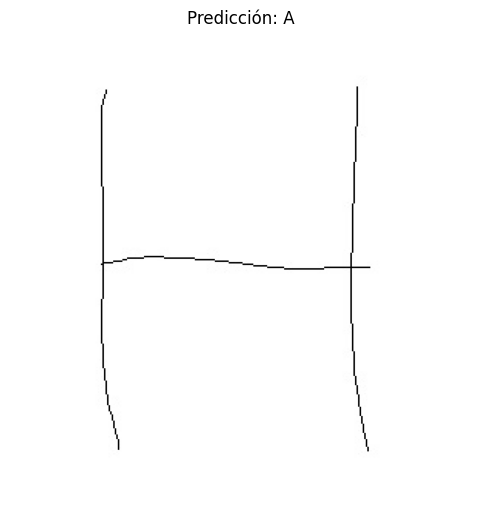

In [4]:
# Importar librerías necesarias para el procesamiento
import numpy as np
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
import joblib

# Cargar el modelo entrenado
try:
    model = joblib.load('letter_recognition_model.joblib')
    print("✅ Modelo cargado correctamente")
except:
    raise Exception("Primero debes ejecutar la celda de entrenamiento")

# Función mejorada de extracción de características
def extract_uci_features(image):
    # Convertir a array numpy y binarizar
    img_array = np.array(image.convert('L'))
    binary_img = img_array < 128  # Umbral para binarizar

    # Encontrar el cuadro delimitador
    rows = np.any(binary_img, axis=1)
    cols = np.any(binary_img, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]] if np.any(rows) else (0, 0)
    x_min, x_max = np.where(cols)[0][[0, -1]] if np.any(cols) else (0, 0)

    # Calcular características básicas
    width = x_max - x_min + 1
    height = y_max - y_min + 1
    onpix = np.sum(binary_img)

    # Calcular momentos estadísticos
    y_idx, x_idx = np.where(binary_img)
    if len(x_idx) > 0:
        x_bar = np.mean(x_idx)
        y_bar = np.mean(y_idx)
        x2bar = np.mean((x_idx - x_bar)**2)
        y2bar = np.mean((y_idx - y_bar)**2)
        xybar = np.mean((x_idx - x_bar) * (y_idx - y_bar))
    else:
        x_bar = y_bar = x2bar = y2bar = xybar = 0

    # Características de bordes
    x_ege = np.sum(binary_img[:, 0]) + np.sum(binary_img[:, -1])
    y_ege = np.sum(binary_img[0, :]) + np.sum(binary_img[-1, :])

    # Construir vector de características
    features = [
        x_min, y_min, width, height, onpix,
        x_bar, y_bar, x2bar, y2bar, xybar,
        x2bar * y_bar, xybar * y_bar,  # aproximaciones
        x_ege, x_ege * height,
        y_ege, y_ege * width
    ]

    return np.array(features)

# Función para procesar imagen y predecir
def predict_letter():
    print("\n📤 Sube una imagen de una letra mayúscula manuscrita...")
    uploaded = files.upload()

    if not uploaded:
        print("No se subió ninguna imagen.")
        return

    image_path = list(uploaded.keys())[0]

    try:
        # Cargar y redimensionar imagen
        img = Image.open(image_path).convert('L')
        img_resized = img.resize((32, 32))

        # Extraer características y predecir
        features = extract_uci_features(img_resized)
        prediction = model.predict(features.reshape(1, -1))[0]

        # Mostrar resultados
        print(f"\n🔠 Predicción del modelo: {prediction}")

        plt.figure(figsize=(6, 6))
        plt.imshow(img, cmap='gray')
        plt.title(f"Predicción: {prediction}", pad=20)
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error procesando la imagen: {str(e)}")

# Ejecutar la predicción
predict_letter()

# Reconstruir imágenes a partir del dataset